In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer

from keras import backend as K
from keras.initializers import RandomUniform, Initializer, Constant
from keras.models import Sequential 
from keras.layers import Dense, Flatten
from keras.layers import Activation
from keras.optimizer_v2 import rmsprop
from keras.optimizer_v2 import adam

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]

In [ ]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [ ]:
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

In [ ]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

In [ ]:
class RBFNet(object):
    def __init__(self, k=2, lr=0.001, epochs=1000, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)

    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
    # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
                loss = (y[i] - F).flatten() ** 2
                # print('Loss: {0:.2f}'.format(loss[0]))
                # backward pass
                error = -(y[i] - F).flatten()
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

In [ ]:
#NUM_SAMPLES = 1000
#X = np.random.uniform(0., 1., NUM_SAMPLES)
#X = np.sort(X, axis=0)

#noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
#y = np.sin(2 * np.pi * X)  + noise

#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
#X_test = np.sort(X_test)
#y_test = np.sin(2 * np.pi * X_test)

# train model using rbf net (a class with fit and predict inside)
#rbfnet = RBFNet(lr=1e-2, k=2)
#rbfnet.fit(X_train, y_train)
#y_pred = rbfnet.predict(X_test)

#train model using rbf layer (a nn layer using rbf function to calculate output vector a)
# X_new = X_train.reshape(len(X_train),1)
# y_new = y_train.reshape(len(y_train),1)
# model = Sequential()
# rbflayer = RBFLayer(16,
                        # initializer=InitCentersKMeans(X_new),
                        # betas=1,
                        # input_shape=(len(X_new[0]),))
# model.add(rbflayer)
# model.add(Dense(1))
#model.add(Activation('sigmoid'))
# model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
            #   loss=tf.keras.losses.MeanSquaredError(),
            #   metrics=tf.keras.metrics.MeanSquaredError())
# print(model.summary())
# history1 = model.fit(X_new, y_new, epochs=500, batch_size=32)
# y_pred_1 = model.predict(X_test)

# train model using svr method
#svr_model = SVR(kernel = 'rbf')
#svr_model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
#y_pred_2 = svr_model.predict(X_test.reshape(-1,1))

#train model using decision tree
#dt_reg = DecisionTreeRegressor()
#dt_reg.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
#y_pred_3 = dt_reg.predict(X_test.reshape(-1,1))

#plt.plot(X_test, y_test, '-o', label='true')
# plt.plot(X_test, y_pred, '-o', label='RBF-Net')
# plt.plot(X_test, y_pred_1, '-o', label='RBF-Net-1')
# plt.plot(X_test, y_pred_2, '-o', label='SVR')
#plt.plot(X_test, y_pred_3, '-o', label='Decision Tree')
#plt.legend()
#plt.tight_layout()
#plt.show()

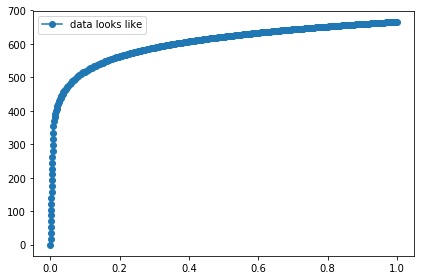

In [3]:
data = np.loadtxt("E:/nmtuan97/1_scripts/data_test.csv", delimiter=',')
X = data[:,:1]
y = data[:,1:2]

X = MinMaxScaler().fit_transform(X)

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
# sorted_x = np.sort(X_train)
# sorted_y = np.sort(y_train)

plt.plot(X, y, '-o', label='data looks like')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# X_test = np.sort(X_test, axis=0)
# y_test = np.sort(y_test, axis=0)

In [ ]:
# train model using rbf net (a class with fit and predict inside)
r2_ = 0.99
r2_train_ = 0.0
r2_test_ = 0.0
max_ = 0
k_ = 100
while r2_test_ < float(r2_):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
    
    rbfnet = RBFNet(lr=1e-3, k=k_)
    rbfnet.fit(X_train, y_train)
    
    y_train_predicted_ = np.mean(rbfnet.predict(X_train).reshape(len(y_train),k_), axis=1)
    y_test_predicted_ = np.mean(rbfnet.predict(X_test).reshape(len(y_test),k_), axis=1)
    
    rmse_train_ = np.sqrt(mean_squared_error(y_train, y_train_predicted_))
    r2_train_ = r2_score(y_train, y_train_predicted_)
    mae_train_ = mean_absolute_error(y_train, y_train_predicted_)
    # Evaluating test dataset
    rmse_test_ = np.sqrt(mean_squared_error(y_test, y_test_predicted_))
    r2_test_ = r2_score(y_test, y_test_predicted_)
    mae_test_ = mean_absolute_error(y_test, y_test_predicted_)
    
    if r2_test_ > max_:
        max_ = r2_test_
        print("R2 score of test is {}".format(max_))
        
print("-------------------------------------------")
print("RMSE of training is {}".format(rmse_train_))
print("R2 score of training  is {}".format(r2_train_))
print("MAE of training is {}".format(mae_train_))
print("RMSE of test is {}".format(rmse_test_))
print("R2 score of test is {}".format(max_))
print("MAE of test is {}".format(mae_test_))
        
# y_pred = rbfnet.predict(X_test)
# y_pred = np.mean(y_pred.reshape(26,40), axis=1)
# y_pred = y_pred.reshape(26,1)
# 
# plt.plot(X_test, y_test, '-o', label='true')
# plt.plot(X_test, y_pred, '-o', label='RBF-Net')
# plt.legend()
# plt.tight_layout()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)

X_test = np.sort(X_test, axis=0)
y_test = np.sort(y_test, axis=0)

y_pred = rbfnet.predict(X_test)
y_pred = np.mean(y_pred.reshape(len(y_test),k_), axis=1)
y_pred = y_pred.reshape(len(y_test),1)
# 
plt.plot(X_test, y_test, '-o', label='true')
plt.plot(X_test, y_pred, '-o', label='RBF-Net')
plt.legend()
plt.tight_layout()

In [ ]:
#train model using rbf layer (a nn layer using rbf function to calculate output vector a)
#X_new = X_train.reshape(len(X_train),1)
#y_new = y_train.reshape(len(y_train),1)

# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# y = ohe.fit_transform(y).toarray()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)

model = Sequential()
rbflayer = RBFLayer(187,
                    initializer=InitCentersKMeans(X_train),
                    betas=16,
                    input_shape=(len(X_train[0]),))
model.add(rbflayer)
model.add(Dense(len(y_train[0])))
#model.add(Activation('sigmoid'))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError())
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=2000, batch_size=8)

In [ ]:
# rbf_model_2 = f"rbf_model_2.h5"
# print(f"Save model to file {rbf_model_2} ... ", end="")
# model.save(rbf_model_2)
# print("OK")

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)

# y_pred_1 = ohe.inverse_transform(model.predict(X_test))
# y_test = ohe.inverse_transform(y_test)

# X_test = np.sort(X_test, axis=0)
# y_test = np.sort(y_test, axis=0)
# plt.plot(X_test, y_test, '-o', label='true')
# plt.plot(X_test, y_pred_1, '-o', label='RBF-Net-2')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [5]:
# train model using svr method
r2_ = 0.9
r2_train_ = 0.0
r2_test_ = 0.0
max_ = 0
while r2_test_ < float(r2_):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
    
    svr_model = SVR(kernel = 'rbf', C=10000, gamma=500)
    svr_model.fit(X_train, y_train)
    
    y_train_predicted_svr_ = svr_model.predict(X_train)
    y_test_predicted_svr_ = svr_model.predict(X_test)
    
    rmse_train_ = np.sqrt(mean_squared_error(y_train, y_train_predicted_svr_))
    r2_train_ = r2_score(y_train, y_train_predicted_svr_)
    mae_train_ = mean_absolute_error(y_train, y_train_predicted_svr_)
    # Evaluating test dataset
    rmse_test_ = np.sqrt(mean_squared_error(y_test, y_test_predicted_svr_))
    r2_test_ = r2_score(y_test, y_test_predicted_svr_)
    mae_test_ = mean_absolute_error(y_test, y_test_predicted_svr_)
    
    if r2_test_ > max_:
        max_ = r2_test_
        print("R2 score of test is {}".format(max_))
        
print("-------------------------------------------")
print("RMSE of training is {}".format(rmse_train_))
print("R2 score of training  is {}".format(r2_train_))
print("MAE of training is {}".format(mae_train_))
print("RMSE of test is {}".format(rmse_test_))
print("R2 score of test is {}".format(max_))
print("MAE of test is {}".format(mae_test_))

c:\Python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


R2 score of test is 0.9889157269067836
-------------------------------------------
RMSE of training is 11.397512912914108
R2 score of training  is 0.992084603641532
MAE of training is 2.974774373512233
RMSE of test is 14.439723767678498
R2 score of test is 0.9889157269067836
MAE of test is 4.40579792868165


Save model to file svr_model.pickle ... OK


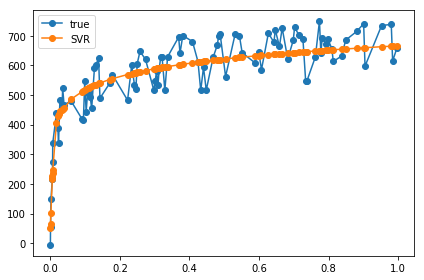

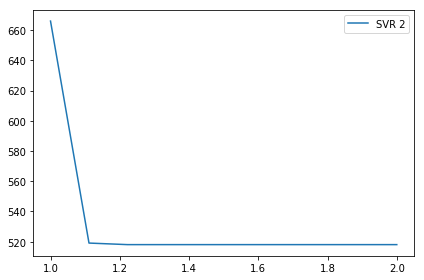

In [17]:
svr_model_ = f"svr_model.pickle"
print(f"Save model to file {svr_model_} ... ", end="")
pickle.dump(svr_model, open(svr_model_, "wb"))
print("OK")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
noise = np.random.uniform(-100, 100, len(y_test)).reshape(len(y_test),1)

X_test = np.sort(X_test, axis=0)
y_test = np.sort(y_test, axis=0) + noise

x_test_0 = np.linspace(1,2,10)
x_test_0 = x_test_0.reshape(len(x_test_0),1)

y_pred_2 = svr_model.predict(X_test)
y_pred_0 = svr_model.predict(x_test_0)

plt.plot(X_test, y_test, '-o', label='true')
plt.plot(X_test, y_pred_2, '-o', label='SVR')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(x_test_0, y_pred_0, '-', label='SVR 2')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
#train model using decision tree
r2_ = 0.99
r2_train_ = 0.0
r2_test_ = 0.0
max_ = 0
while r2_test_ < float(r2_):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
    
    dt_reg = DecisionTreeRegressor()
    dt_reg.fit(X_train, y_train)
    
    y_train_predicted_svr_ = dt_reg.predict(X_train)
    y_test_predicted_svr_ = dt_reg.predict(X_test)
    
    rmse_train_ = np.sqrt(mean_squared_error(y_train, y_train_predicted_svr_))
    r2_train_ = r2_score(y_train, y_train_predicted_svr_)
    mae_train_ = mean_absolute_error(y_train, y_train_predicted_svr_)
    # Evaluating test dataset
    rmse_test_ = np.sqrt(mean_squared_error(y_test, y_test_predicted_svr_))
    r2_test_ = r2_score(y_test, y_test_predicted_svr_)
    mae_test_ = mean_absolute_error(y_test, y_test_predicted_svr_)
    
    if r2_test_ > max_:
        max_ = r2_test_
        print("R2 score of test is {}".format(max_))
        
print("-------------------------------------------")
print("RMSE of training is {}".format(rmse_train_))
print("R2 score of training  is {}".format(r2_train_))
print("MAE of training is {}".format(mae_train_))
print("RMSE of test is {}".format(rmse_test_))
print("R2 score of test is {}".format(max_))
print("MAE of test is {}".format(mae_test_))

R2 score of test is 0.9975199634655877
-------------------------------------------
RMSE of training is 0.0
R2 score of training  is 1.0
MAE of training is 0.0
RMSE of test is 7.586424433863495
R2 score of test is 0.9975199634655877
MAE of test is 3.684012769892472


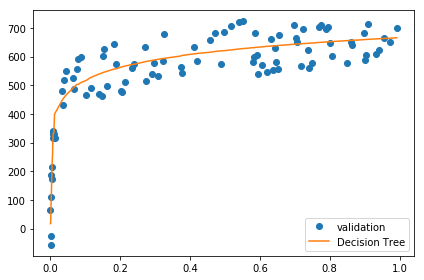

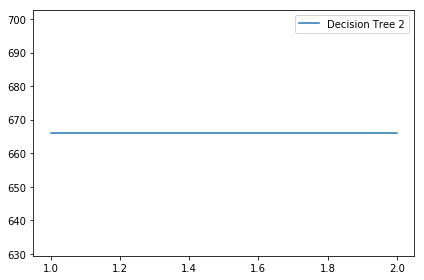

In [16]:
# dt_model_ = f"dt_model.pickle"
# print(f"Save model to file {dt_model_} ... ", end="")
# pickle.dump(dt_reg, open(dt_model_, "wb"))
# print("OK")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
noise = np.random.uniform(-100, 100, len(y_test)).reshape(len(y_test),1)

X_test = np.sort(X_test, axis=0)
y_test = np.sort(y_test, axis=0) + noise

x_test_1 = np.linspace(1,2,10)
x_test_1 = x_test_1.reshape(len(x_test_1),1)

y_pred_3 = dt_reg.predict(X_test)
y_pred_4 = dt_reg.predict(x_test_1)

plt.plot(X_test, y_test, 'o', label='validation')
plt.plot(X_test, y_pred_3, '-', label='Decision Tree')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(x_test_1, y_pred_4, '-', label='Decision Tree 2')
plt.legend()
plt.tight_layout()
plt.show()